# Exploración inicial

In [15]:
from pathlib import Path
import pandas as pd
import openpyxl
from enum import StrEnum
from tqdm import tqdm

### Cargar datos y comprobar su estructura

In [6]:
DATA_DIR = Path('data').resolve()

ENERO_PATH = DATA_DIR / 'Enero-2021.xlsx'
FEBRERO_PATH = DATA_DIR / 'Febrero-2021.xlsx'
MARZO_PATH = DATA_DIR / 'Marzo-2021.xlsx'
ABRIL_PATH = DATA_DIR / 'Abril-2021.xlsx'

In [5]:
def get_sheet_names(path: str) -> list[str]:
    """Get the sheet names from an Excel file."""
    wb = openpyxl.load_workbook(path)
    return wb.sheetnames

In [7]:
for path in [ENERO_PATH, FEBRERO_PATH, MARZO_PATH, ABRIL_PATH]:
    print(get_sheet_names(path))

['Servicios', 'RepLegales', 'Vehiculos', 'O-D Recorridos', 'Trazados']
['Servicio', 'RepLegales', 'Vehículo', 'O-D Recorrido', 'Trazado']
['Servicio', 'RepLegales', 'Vehiculos vig', 'O-D Recorrido', 'Trazados']
['Servicios', 'Replegal', 'Vehículos', 'O-D Recorridos', 'Trazados']


Podemos ver que para distintos meses, los archivos de excel tienen nombres de pestañas distintos pero que se refieren a los mismo, por lo que podemos hacer una función para arreglarlo

In [9]:
def normalize_sheet_names(path: str, sheet_names: list[str]) -> None:
    """
    Normalize the sheet names in an Excel file.
    Args:
        path: The path to the Excel file.
        sheet_names: The list of sheet names (in order) to rename the sheets to.
    Returns:
        None
    """
    wb = openpyxl.load_workbook(path)
    for sheet_name, new_sheet_name in zip(wb.sheetnames, sheet_names):
        wb[sheet_name].title = new_sheet_name
    wb.save(path)

In [11]:
class TableName(StrEnum):
    SERVICIOS = 'Servicios'
    REP_LEGALES = 'RepLegales'
    VEHICULOS = 'Vehiculos'
    O_D_RECORRIDOS = 'O-D Recorridos'
    TRAZADOS = 'Trazados'
    
    @classmethod
    def get_sheet_names(cls) -> list[str]:
        return [table_name.value for table_name in cls]

In [12]:
TableName.get_sheet_names()

['Servicios', 'RepLegales', 'Vehiculos', 'O-D Recorridos', 'Trazados']

In [ ]:
normalized_names = TableName.get_sheet_names()

for path in [ENERO_PATH, FEBRERO_PATH, MARZO_PATH, ABRIL_PATH]:
    normalize_sheet_names(path, normalized_names)

En este punto ya tenemos los datos de los archivos de excel con nombres de pestañas normalizados, por lo que podemos empezar a trabajar con ellos

In [17]:
def get_data(path: str, sheet_name: str) -> pd.DataFrame:
    """Get the data from an Excel file."""
    return pd.read_excel(path, sheet_name=sheet_name)

data = {
    'Enero-2021': {},
    'Febrero-2021': {},
    'Marzo-2021': {},
    'Abril-2021': {},
}

Procedemos a cargar los datos

In [18]:

for path in [ENERO_PATH, FEBRERO_PATH, MARZO_PATH, ABRIL_PATH]:
    for sheet_name in tqdm(TableName.get_sheet_names(), desc=path.stem):
        data[path.stem][sheet_name] = get_data(path, sheet_name)

Abril-2021: 100%|██████████| 5/5 [01:33<00:00, 18.74s/it]


## Análisis exploratorio

### Número de tuplas y homogeteneidad de los datos por meses

Veamos cuántas tuplas hay por tabla

In [22]:
number_of_lines = {}
for month, tables in data.items():
    number_of_lines[month] = {}
    for table_name, df in tables.items():
        number_of_lines[month][table_name] = df.shape[0]
        
number_of_lines = pd.DataFrame(number_of_lines).T

In [23]:
number_of_lines

,Servicios,RepLegales,Vehiculos,O-D Recorridos,Trazados
Enero-2021,41508,4499,136354,11138,324659
Febrero-2021,41495,4487,136143,11143,324581
Marzo-2021,41551,4495,136069,11189,325220
Abril-2021,41525,4489,136031,11209,326154


In [24]:
number_of_lines.sum(axis=1)

Enero-2021      518158
Febrero-2021    517849
Marzo-2021      518524
Abril-2021      519408
dtype: int64

Como podemos ver, cada tabla archivo de excel (por mes) tiene aproximadamente una suma de 500.000 tuplas, por lo que, dado que se indicó que el número de tuplas total debe estar entre 100.000 y 1.000.000, podremos tomar como máximo 2 meses de datos. Estos se pasan por un poquito de un millón de tuplas, pero existe la posibilidad de que tras la limpieza de datos tengamos que borrar algunos por lo que preferimos tomar un margen de seguridad. Si por el contrario, tras la normalización de datos el número de tuplas aumenta demasiado, siempre podremos botar un mes, lo cual debería bastar para cumplir con el rango de tuplas.

In [38]:
column_names = {}
for month, tables in data.items():
    column_names[month] = {}
    for table_name, df in tables.items():
        column_names[month][table_name] = set(df.columns)


In [54]:
column_numbers = pd.DataFrame(column_names).T
column_numbers = column_numbers.applymap(lambda x: len(x))
print('Número de columnas por tabla y mes')
column_numbers

Número de columnas por tabla y mes


,Servicios,RepLegales,Vehiculos,O-D Recorridos,Trazados
Enero-2021,16,4,9,12,10
Febrero-2021,15,4,9,11,10
Marzo-2021,15,4,9,11,9
Abril-2021,15,4,9,11,9


Podemos ver que el número de columnas por tabla por mes no es homogéneo, excepto para marzo y abril, es por esto que por simplicidad tomaremos estos dos meses.

In [55]:
for month, tables in data.items():
    for table_name, df in tables.items():
        print(f'{month}: {table_name}')
        print(df.columns)
        print()

Enero-2021: Servicios
Index(['REGION', 'FOLIO', 'CONCA', 'TIPOSERVICIO', 'NRO_LINEA',
       'FLOTA VIGENTE', 'RUT_RESPONSABLE', 'NOMBRE_RESPONSABLE',
       'NOMBRE_FANTASIA', 'TIPO_PERSONA', 'COMUNA', 'REGION.1', 'DOMICILIO',
       'TELEFONO', 'FAX', 'EMAIL'],
      dtype='object')

Enero-2021: RepLegales
Index(['REGION', 'FOLIO', 'TIPOSERVICIO', 'NOMBRE_REPLEGAL'], dtype='object')

Enero-2021: Vehiculos
Index(['REGION', 'FOLIO', 'TIPOSERVICIO', 'PPU', 'FECHA_INGRESO_RNT', 'MARCA',
       'MODELO', 'ANOFABRICACION', 'CAPACIDAD'],
      dtype='object')

Enero-2021: O-D Recorridos
Index(['REGION', 'FOLIO', 'TIPOSERVICIO', 'NOMBRE_RECORRIDO', 'TIPO_TRAZADO',
       'LONGITUD_TRAZADO', 'NOMBRE_ORIGEN', 'COMUNA_ORIGEN',
       'DOMICILIO_ORIGEN', 'NOMBRE_DESTINO', 'COMUNA_DESTINO',
       'DOMICILIO_DESTINO'],
      dtype='object')

Enero-2021: Trazados
Index(['REGION', 'FOLIO', 'TIPOSERVICIO', 'NOMBRE_RECORRIDO', 'TIPO_TRAZADO',
       'ORDEN', 'LINEA', 'SENTIDO', 'CALLE', 'COMUNA'],
  

Veamos si los nombres de las columnas de Marzo y Abril son los mismos

In [65]:
column_names_recent = column_names[['Marzo-2021', 'Abril-2021']].copy()
column_names_recent['union'] = column_names_recent.apply(lambda x: x['Marzo-2021'].union(x['Abril-2021']), axis=1)
column_names_recent['intersection'] = column_names_recent.apply(lambda x: x['Marzo-2021'].intersection(x['Abril-2021']), axis=1)
column_names_recent['difference'] = column_names_recent.apply(lambda x: x['Marzo-2021'].difference(x['Abril-2021']), axis=1)
column_names_recent

,Marzo-2021,Abril-2021,union,intersection,difference
Servicios,"{TIPO_PERSONA, REGION, TIPO_SERVICIO, EMAIL, D...","{TIPO_PERSONA, REGION, FLOTA VIGENTE, TIPO_SER...","{TIPO_PERSONA, REGION, FLOTA VIGENTE, TIPO_SER...","{TIPO_PERSONA, REGION, NRO_LINEA, TIPO_SERVICI...",{FLOTA VIGENTE}
RepLegales,"{REGION, TIPO_SERVICIO, FOLIO, NOMBRE_REPLEGAL}","{REGION, TIPO_SERVICIO, FOLIO, NOMBRE_REPLEGAL}","{NOMBRE_REPLEGAL, REGION, TIPO_SERVICIO, FOLIO}","{REGION, TIPO_SERVICIO, FOLIO, NOMBRE_REPLEGAL}",{}
Vehiculos,"{MARCA, REGION, FECHA_INGRESO_RNT, TIPO_SERVIC...","{MARCA, REGION, FECHA_INGRESO_RNT, TIPO_SERVIC...","{MARCA, REGION, FECHA_INGRESO_RNT, TIPO_SERVIC...","{MARCA, REGION, FECHA_INGRESO_RNT, TIPO_SERVIC...",{}
O-D Recorridos,"{COMUNA_ORIGEN, DOMICILIO_DESTINO, NOMBRE_ORIG...","{COMUNA_ORIGEN, DOMICILIO_DESTINO, NOMBRE_ORIG...","{COMUNA_ORIGEN, DOMICILIO_DESTINO, NOMBRE_ORIG...","{COMUNA_ORIGEN, DOMICILIO_DESTINO, NOMBRE_ORIG...",{}
Trazados,"{REGION, TIPO_SERVICIO, ORDEN, NOMBRE_RECORRID...","{REGION, TIPO_SERVICIO, ORDEN, NOMBRE_RECORRID...","{REGION, TIPO_SERVICIO, ORDEN, NOMBRE_RECORRID...","{REGION, TIPO_SERVICIO, ORDEN, NOMBRE_RECORRID...",{}


In [66]:
display(
    data['Marzo-2021']['Servicios'].columns,
    data['Abril-2021']['Servicios'].columns,
)

Index(['REGION', 'FOLIO', 'TIPO_SERVICIO', 'FLOTA  VIGENTE', 'NRO_LINEA',
       'RUT_RESPONSABLE', 'NOMBRE_RESPONSABLE', 'NOMBRE_FANTASIA',
       'TIPO_PERSONA', 'COMUNA', 'REGION.1', 'DOMICILIO', 'TELEFONO', 'FAX',
       'EMAIL'],
      dtype='object')

Index(['REGION', 'FOLIO', 'TIPO_SERVICIO', 'FLOTA VIGENTE', 'NRO_LINEA',
       'RUT_RESPONSABLE', 'NOMBRE_RESPONSABLE', 'NOMBRE_FANTASIA',
       'TIPO_PERSONA', 'DOMICILIO', 'COMUNA', 'REGION.1', 'TELEFONO', 'FAX',
       'EMAIL'],
      dtype='object')

Podemos ver que sí, excepto para la columna "FLOTA VIGENTE" de la tabla "Servicios", la cual simplemente se equivocaron y le agregaron un espacio de más. Así que en realidad podemos decir que los nombres de las columnas son los mismos.

Para lo que sigue, usaremos sólo los datos de abril por simplicidad, asumiendo que no debe ser muy distinto para marzo y sabiendo que en el peor de los casos (si llegaran a haber sorpresas en cuanto a los datos de abril), nos bastaría sólo usar los datos de marzo

### Porcentaje de valores nulos

In [88]:
MES = 'Abril-2021'

servicios = data[MES][TableName.SERVICIOS].copy()
rep_legales = data[MES][TableName.REP_LEGALES].copy()
vehiculos = data[MES][TableName.VEHICULOS].copy()
recorridos = data[MES][TableName.O_D_RECORRIDOS].copy()
trazados = data[MES][TableName.TRAZADOS].copy()


In [95]:
servicios.head()

,REGION,FOLIO,TIPO_SERVICIO,FLOTA VIGENTE,NRO_LINEA,RUT_RESPONSABLE,NOMBRE_RESPONSABLE,NOMBRE_FANTASIA,TIPO_PERSONA,DOMICILIO,COMUNA,REGION.1,TELEFONO,FAX,EMAIL
0,1,10,TAXI COLECTIVO RURAL,1,NaN,NaN,FRANCISCO R. CARLOS MAMANI,NaN,NATURAL,NaN,NaN,NaN,NaN,NaN,NaN
1,1,4608,TAXI COLECTIVO RURAL,1,NaN,NaN,JORGE ANDRES SOTO LARA,NaN,NATURAL,NaN,NaN,NaN,NaN,NaN,NaN
2,1,27,TAXI COLECTIVO RURAL,1,NaN,NaN,RENE RUPERTO OYANADEL RIVEROS,NaN,NATURAL,NaN,NaN,NaN,NaN,NaN,NaN
3,1,67,TAXI COLECTIVO RURAL,1,,NaN,JOSE LINO CUELLO YA?EZ,NaN,NATURAL,NaN,NaN,NaN,NaN,NaN,NaN
4,1,4917,TAXI COLECTIVO RURAL,1,NaN,NaN,LUIS PEDRO BOTTARELLI ARROYO,NaN,NATURAL,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
servicios[servicios['TIPO_PERSONA'] == 'JURIDICA'].head()

,REGION,FOLIO,TIPO_SERVICIO,FLOTA VIGENTE,NRO_LINEA,RUT_RESPONSABLE,NOMBRE_RESPONSABLE,NOMBRE_FANTASIA,TIPO_PERSONA,DOMICILIO,COMUNA,REGION.1,TELEFONO,FAX,EMAIL
37,3,6000,TAXI COLECTIVO RURAL,63,3,72775200-5,SINDICATO DE TRABAJADORES INDEPENDIENTES DUE?...,LINEA N? 3,JURIDICA,LOS AROMOS N? 1960 POBLACION SANTA ELVIRA,Copiapó,DE ATACAMA,52-218106,975522818,NaN
38,3,6005,TAXI COLECTIVO RURAL,3,10,76928700-0,MU?OZ E HIJOS Y CÍA. LTDA.,TRANS-O.M.G. LTDA.,JURIDICA,AVENIDA ARICA N? 727,Caldera,DE ATACAMA,97932214,NaN,EMPRESAOMG@YAHOO.COM
39,3,6003,TAXI COLECTIVO RURAL,55,88,73686800-8,SINDICATO DE TRABAJADORES INDEPENDIENTES DE DU...,LINA 88,JURIDICA,"LLANOS DE AGUAS BLANCAS 5960, LLANOS DE OLLANYAY",Tierra Amarilla,DE ATACAMA,958893957,NaN,RODRI.GAU@HOTMAIL.COM
40,3,5002,TAXI COLECTIVO RURAL,12,NaN,72661000-2,SINDICATO TRABAJADORES TAXIS COLECTIVOS,VALLE DEL HUASCO,JURIDICA,AV. BRASIL N? 711,Vallenar,DE ATACAMA,NaN,64952792,NaN
115,4,120,TAXI COLECTIVO RURAL,13,NaN,72621000-4,SIND. DE TRABAJADORES INDEPENDIENTES DE DUE?OS...,TACSO,JURIDICA,ARIZTIA PONIENTE 159,La Serena,DE COQUIMBO,215507,(53)630989,TACSOOVALLE@HOTMAIL.COM


In [96]:
servicios['TIPO_PERSONA'].value_counts()

TIPO_PERSONA
NATURAL     38351
JURIDICA     3174
Name: count, dtype: int64

In [104]:
def porcentaje_de_nulos(df: pd.DataFrame) -> pd.DataFrame:
    """Get the percentage of null values in each column of a DataFrame."""
    nulls = df.isnull().sum() / df.shape[0] * 100
    return nulls.to_frame('Porcentaje de nulos')


In [ ]:
nulls_servicios = porcentaje_de_nulos(servicios)
nulls_servicios

Podemos ver que los datos de los servicios tienen muchos valores nulos, esto se debe a que estas columnas contienen información únicamente de aquellas lineas que tratan de una persona jurídica en lugar de una persona natural, la información de los registros de personas naturales se encuentra en
la tabla de RepLegal. Por lo tanto, no es que falte información, sólo está organizada de manera distinta, por lo que tras una normalización de datos aquí no debería haber un gran porcentaje de valores nulos. 

In [105]:
porcentaje_de_nulos(rep_legales)

,Porcentaje de nulos
REGION,0.0
FOLIO,0.0
TIPO_SERVICIO,0.0
NOMBRE_REPLEGAL,0.0


In [107]:
porcentaje_de_nulos(vehiculos)

,Porcentaje de nulos
REGION,0.000000
FOLIO,0.000000
TIPO_SERVICIO,0.000000
PPU,0.000000
FECHA_INGRESO_RNT,0.000000
MARCA,0.000000
MODELO,0.003676
ANO_FABRICACION,0.000000
CAPACIDAD,25.409649


In [108]:
porcentaje_de_nulos(recorridos)

,Porcentaje de nulos
REGION,0.000000
FOLIO,0.000000
TIPO_SERVICIO,0.000000
NOMBRE_RECORRIDO,0.000000
TIPO_TRAZADO,0.000000
NOMBRE_ORIGEN,0.000000
COMUNA_ORIGEN,0.695869
DOMICILIO_ORIGEN,5.763226
NOMBRE_DESTINO,0.000000
COMUNA_DESTINO,1.043804


In [110]:
porcentaje_de_nulos(trazados)

,Porcentaje de nulos
REGION,0.000000
FOLIO,0.000000
TIPO_SERVICIO,0.000000
NOMBRE_RECORRIDO,0.000000
TIPO_TRAZADO,0.000000
ORDEN,0.000000
SENTIDO,0.000000
CALLE,0.000000
COMUNA,0.000307


Tras ver estas tablas podemos ver que tienen un número reducido de nulos, por lo que es probable que los datos sean útiles y que no requieran de una limpieza muy exhaustiva.

### Dominio de los valores

A continuación se muestran los dominios de los valores de las columnas de las tablas de abril (consideremos object como string)

In [111]:
for df in [servicios, rep_legales, vehiculos, recorridos, trazados]:
    display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41525 entries, 0 to 41524
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   REGION              41525 non-null  int64 
 1   FOLIO               41525 non-null  int64 
 2   TIPO_SERVICIO       41525 non-null  object
 3   FLOTA VIGENTE       41525 non-null  int64 
 4   NRO_LINEA           2043 non-null   object
 5   RUT_RESPONSABLE     3174 non-null   object
 6   NOMBRE_RESPONSABLE  41525 non-null  object
 7   NOMBRE_FANTASIA     1784 non-null   object
 8   TIPO_PERSONA        41525 non-null  object
 9   DOMICILIO           3171 non-null   object
 10  COMUNA              3167 non-null   object
 11  REGION.1            3167 non-null   object
 12  TELEFONO            3006 non-null   object
 13  FAX                 611 non-null    object
 14  EMAIL               2201 non-null   object
dtypes: int64(3), object(12)
memory usage: 4.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4489 entries, 0 to 4488
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   REGION           4489 non-null   int64 
 1   FOLIO            4489 non-null   int64 
 2   TIPO_SERVICIO    4489 non-null   object
 3   NOMBRE_REPLEGAL  4489 non-null   object
dtypes: int64(2), object(2)
memory usage: 140.4+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136031 entries, 0 to 136030
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   REGION             136031 non-null  int64  
 1   FOLIO              136031 non-null  int64  
 2   TIPO_SERVICIO      136031 non-null  object 
 3   PPU                136031 non-null  object 
 4   FECHA_INGRESO_RNT  136031 non-null  object 
 5   MARCA              136031 non-null  object 
 6   MODELO             136026 non-null  object 
 7   ANO_FABRICACION    136031 non-null  int64  
 8   CAPACIDAD          101466 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 9.3+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11209 entries, 0 to 11208
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   REGION             11209 non-null  int64 
 1   FOLIO              11209 non-null  int64 
 2   TIPO_SERVICIO      11209 non-null  object
 3   NOMBRE_RECORRIDO   11209 non-null  object
 4   TIPO_TRAZADO       11209 non-null  object
 5   NOMBRE_ORIGEN      11209 non-null  object
 6   COMUNA_ORIGEN      11131 non-null  object
 7   DOMICILIO_ORIGEN   10563 non-null  object
 8   NOMBRE_DESTINO     11209 non-null  object
 9   COMUNA_DESTINO     11092 non-null  object
 10  DOMICILIO_DESTINO  10148 non-null  object
dtypes: int64(2), object(9)
memory usage: 963.4+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326154 entries, 0 to 326153
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   REGION            326154 non-null  int64 
 1   FOLIO             326154 non-null  int64 
 2   TIPO_SERVICIO     326154 non-null  object
 3   NOMBRE_RECORRIDO  326154 non-null  object
 4   TIPO_TRAZADO      326154 non-null  object
 5   ORDEN             326154 non-null  int64 
 6   SENTIDO           326154 non-null  object
 7   CALLE             326154 non-null  object
 8   COMUNA            326153 non-null  object
dtypes: int64(3), object(6)
memory usage: 22.4+ MB


None

### Distribuciones importantes

Una de las cosas más interesantes para ver es la distribución de tipos de servicio y ver qué valores puede tomar:

<AxesSubplot: xlabel='TIPO_SERVICIO'>

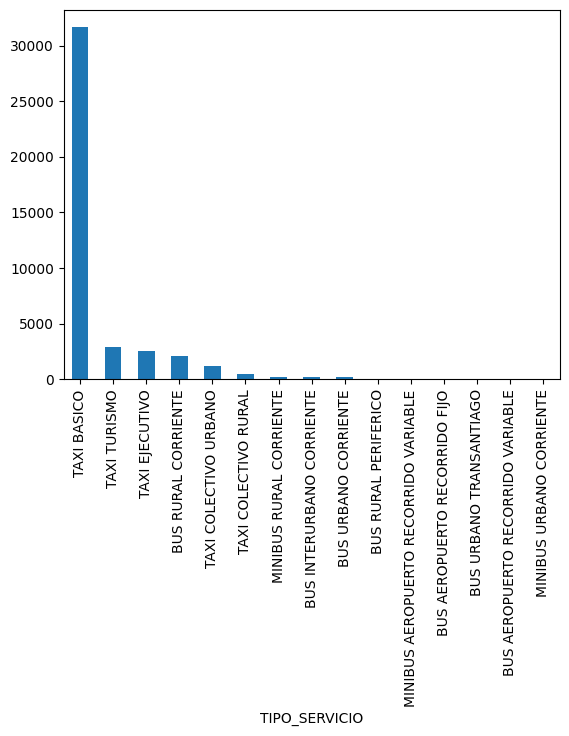

In [117]:
servicios["TIPO_SERVICIO"].value_counts().plot(kind='bar')

Una de las cosas más imporantes es el tipo de servicio con el que vamos a trabajar, podemos ver que se trata principalmente de taxis. Seguramente ya que son muchos más, pero también están las micros.